In [3]:
import numpy as np
import pandas as pd
import json
import codecs
import datetime
import os
import sys

In [4]:
sys.path.append('.')

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (24, 16)

In [6]:
import oci
import json
from oci.config import validate_config
from sklearn.covariance import MinCovDet 

In [7]:
tenancyId="ocid1.tenancy.oc1..aaaaaaaahkzl4rzvgxjfnrfcj7rzlsdav25h7tsx7kjxyv2bmwkfpzpag26q" # Your tenancies OCID.
authUserId="ocid1.user.oc1..aaaaaaaayltryoz33ole5eubwphwijkcvmi4ukbombh4aym2crp5j6xqxaxq" # The OCID of the user ID being used.
OCI_KEY_PATH="/home/datascience/.oci/oci_api_key.pem" # Path of the key file.
keyFingerprint="9a:47:38:96:c8:4d:bf:7e:32:3d:7c:c3:24:23:71:35" # The fingerprint of the key file being used
namespace = "lrzustouvvrg"
bucket_name = "sdk-initial-data-bucket"
config = {
    "user": authUserId,
    "key_file": OCI_KEY_PATH,
    "fingerprint": keyFingerprint,
    "tenancy": tenancyId,
    "region": "uk-london-1"
}

In [8]:
validate_config(config)

In [9]:
object_storage_client = oci.object_storage.ObjectStorageClient(config)
next_starts_with = None
object_list = object_storage_client.list_objects(namespace, bucket_name , fields='name, timeCreated, size', start=next_starts_with)

In [10]:
f = object_list.data.objects

In [11]:
f[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [12]:
object_list.data.objects[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "005b6c49-c4ed-438b-9092-ad02ed4d672e_26-07-2021_13-36-18.json",
  "size": 530965,
  "storage_tier": null,
  "time_created": "2021-07-26T05:36:31.229000+00:00",
  "time_modified": null
}

In [13]:
len(f)

1000

In [14]:
obj = object_storage_client.get_object(namespace, bucket_name, f[0].name).data

In [15]:
type(obj.content)

bytes

In [16]:
j_obj = json.loads(obj.content)

In [17]:
type(j_obj)

dict

In [18]:
from vector_creator.score_vectors.score_vectors_assembly import score_vector_from_bucket

In [ ]:
res0 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [20]:
res0.columns

Index(['median daily number photos - location',
       'mad daily number photos - scale', 'mean number of photos in burst',
       'mean number of bursts a week', 'median number of bursts a week',
       'median night time number photos', 'mad night time number photos',
       'median day time number photos', 'mad day time number photos',
       'median weekend number photos', 'mad weekend number photos',
       'median work days number photos', 'mad work days number photos',
       'ar daily num of photos lag-1', 'entropy on daily photos'],
      dtype='object', name='description')

In [21]:
res0.to_csv('csv_files/photogallery_ver3_0.csv')

In [22]:
next_starts_with = object_list.data.next_start_with

In [23]:
osc = object_storage_client.list_objects(namespace, bucket_name, start=next_starts_with, fields='name, timeCreated, size')
g = osc.data.objects
g[0]

{
  "archival_state": null,
  "etag": null,
  "md5": null,
  "name": "78c170cc-9641-4925-bc48-6d0a6538d003_01-08-2021_21-49-56.json",
  "size": 35493,
  "storage_tier": null,
  "time_created": "2021-08-01T13:49:57.369000+00:00",
  "time_modified": null
}

In [25]:
next_starts_with

'78c170cc-9641-4925-bc48-6d0a6538d003_01-08-2021_21-49-56.json'

In [ ]:
res1 = score_vector_from_bucket(object_storage_client, 'photo-gallery', next_starts_with)

In [27]:
res1.to_csv('csv_files/photogallery_ver3_1.csv')

In [28]:
res = res0.append(res1)

In [29]:
res.shape

(1116, 15)

In [30]:
res.to_csv('csv_files/photogallery_ver3.csv')

In [33]:
res.index.is_unique

True

In [34]:
inxs = res.index.values

In [35]:
len(inxs)

1116

In [111]:
df0 = pd.read_csv('csv_files/photogallery_ver3.csv')
df1 = df0.set_index('Unnamed: 0')
df1.head(5)

,median daily number photos - location,mad daily number photos - scale,mean number of photos in burst,mean number of bursts a week,median number of bursts a week,median night time number photos,mad night time number photos,median day time number photos,mad day time number photos,median weekend number photos,mad weekend number photos,median work days number photos,mad work days number photos,ar daily num of photos lag-1,entropy on daily photos
Unnamed: 0,,,,,,,,,,,,,,,
005b6c49-c4ed-438b-9092-ad02ed4d672e,2.0,1.482602,1.233292,0.702624,0.0,2.0,1.482602,2.0,1.482602,2.0,1.482602,2.0,1.482602,17.050272,7.228774
007a0785-1321-4112-be89-e6549a4725a2,3.0,2.965204,2.310658,1.816850,0.0,3.0,2.965204,3.0,2.965204,3.5,3.706506,3.0,2.965204,34.620526,4.114481
00e37960-250f-4185-94ac-143b319730e3,3.0,2.965204,1.152985,1.827586,1.0,2.0,1.482602,2.0,1.482602,3.0,2.965204,3.0,2.965204,5.616712,6.318157
01ae3991-50dc-4a67-9c37-cc88ddea90a2,2.0,1.482602,1.221239,0.863636,0.0,2.0,1.482602,2.0,1.482602,2.0,1.482602,2.0,1.482602,2.301788,5.804842
01c59096-22f1-40fa-b771-49725b91cc93,2.0,1.482602,1.470120,1.600000,1.0,1.5,0.741301,2.0,1.482602,2.0,1.482602,2.0,1.482602,1.077263,6.197594


In [36]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import pandas as pd

In [38]:
from vector_creator.stats_models.estimators import *

In [39]:
nz = z_score(res.values)

In [41]:
nz.shape

(1116, 15)

--> Start tSNE for 2D 

In [42]:
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300, method='exact')

In [43]:
tsne_res = tsne.fit_transform(nz)

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 1000 / 1116
[t-SNE] Computed conditional probabilities for sample 1116 / 1116
[t-SNE] Mean sigma: 0.772342
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.603747
[t-SNE] KL divergence after 300 iterations: 0.998013


In [44]:
df = pd.DataFrame(tsne_res, columns=['x_col', 'y_col'], index=inxs)

In [45]:
df.shape

(1116, 2)

In [46]:
df.head(5)

,x_col,y_col
005b6c49-c4ed-438b-9092-ad02ed4d672e,-9.204374,8.543803
007a0785-1321-4112-be89-e6549a4725a2,-15.056218,6.351846
00e37960-250f-4185-94ac-143b319730e3,0.284761,7.837973
01ae3991-50dc-4a67-9c37-cc88ddea90a2,10.838945,0.655456
01c59096-22f1-40fa-b771-49725b91cc93,12.055403,-3.184467


<AxesSubplot:xlabel='x_col', ylabel='y_col'>

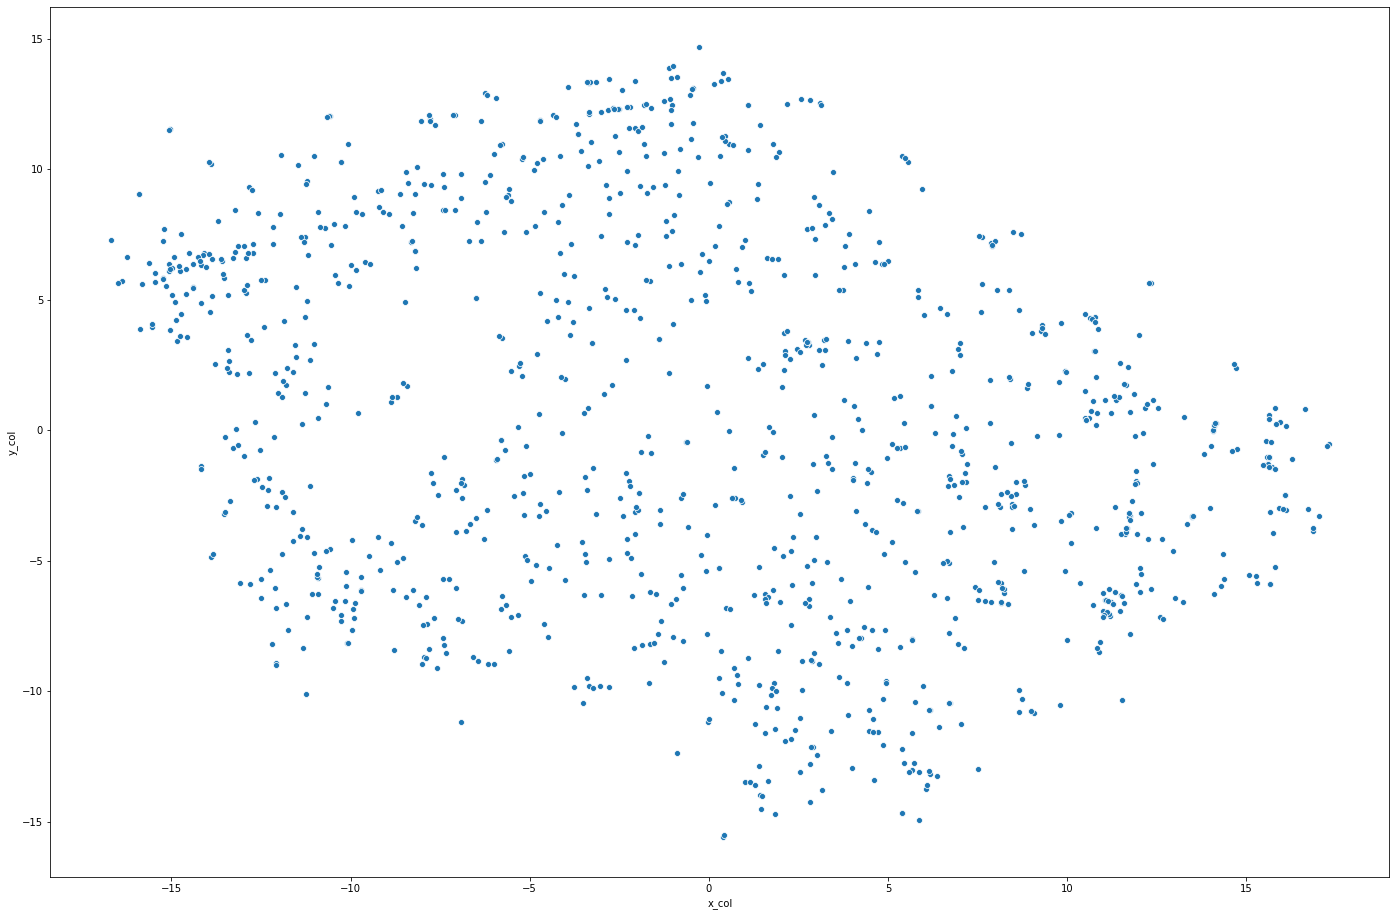

In [47]:
plt.figure()
sns.scatterplot(
    x='x_col', 
    y='y_col',
    data=df
)

--> Mean Shift for tSNE-2D data frame

In [82]:
bandwidth = estimate_bandwidth(df, quantile=0.25)

In [83]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=False, cluster_all=False)
ms.fit(df)

MeanShift(bandwidth=9.073128156127307, cluster_all=False)

In [84]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [85]:
cluster_centers

array([[ 6.2533574, -3.2943182],
       [-7.15977  ,  7.2886324],
       [-5.042539 , -3.6316292]], dtype=float32)

In [86]:
labels_unique

array([-1,  0,  1,  2])

In [87]:
n_clusters_

4

--> Plot tSNE mean-shift 2D with uids as index to df 

b [ 6.2533574 -3.2943182] 0
g [-7.15977    7.2886324] 1
r [-5.042539  -3.6316292] 2


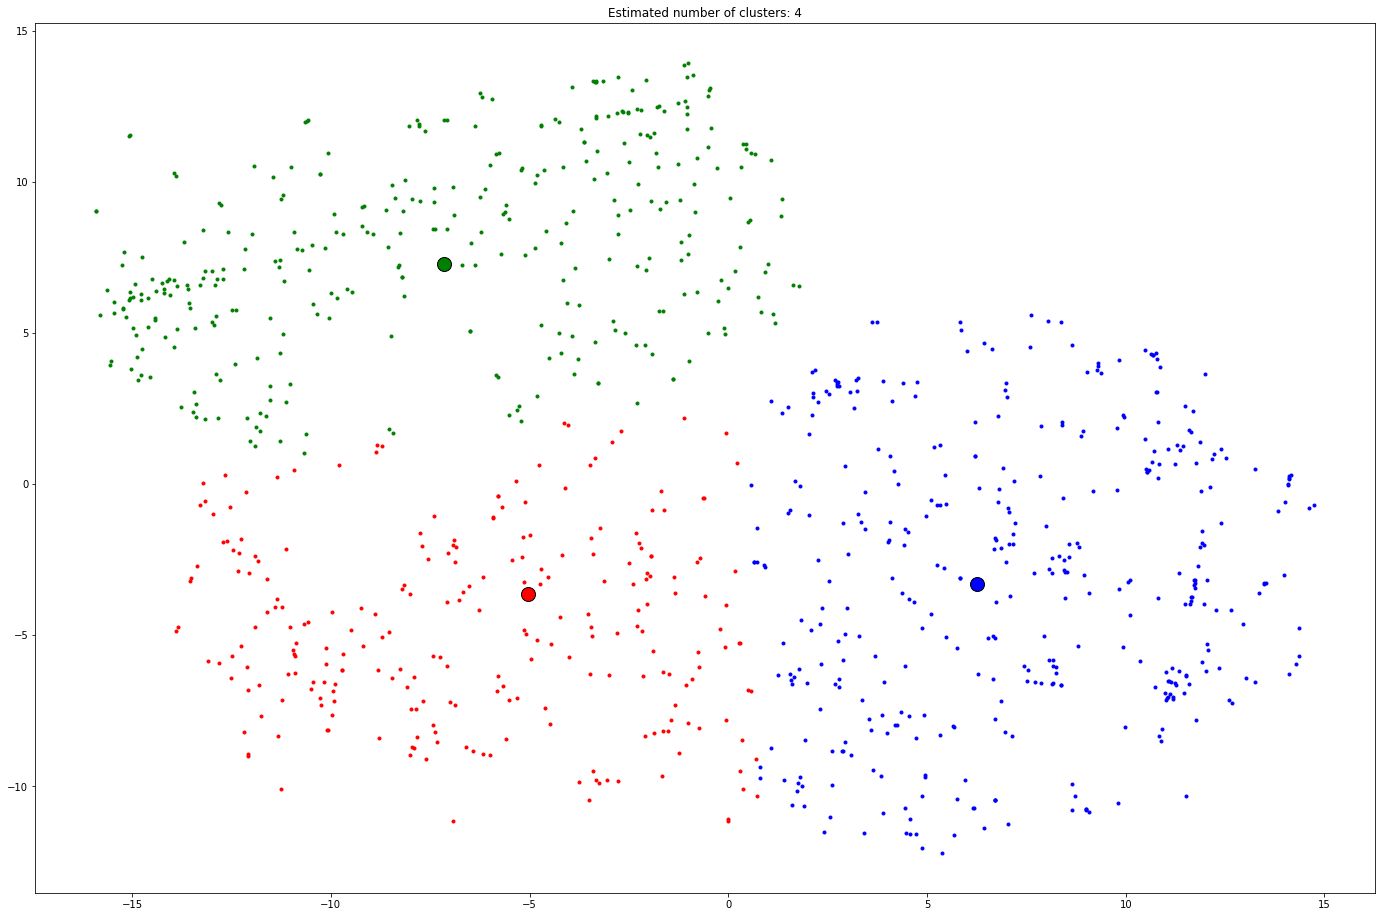

In [88]:
plt.figure()
plt.clf()
X = df.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_-1), colors):
    my_members = labels == k
    print(col, cluster_centers[k], k)
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [89]:
lbls = np.unique(ms.labels_)

In [90]:
res['labels']= ms.labels_

In [91]:
lbls

array([-1,  0,  1,  2])

In [92]:
def createdf_dict_by_lbl():
    df_dict = {}
    df_anom = {}
    for i in np.nditer(lbls):
        lbl = 'label-' + str(i)
        df_lbl_i = res[res.labels == i]
        del df_lbl_i['labels']
        df_dict[lbl] = df_lbl_i
    return df_dict
    
def create_df_by_func(func):
    for i in np.nditer(lbls):
        if i >= 0:
            df_lbl_i = res[res.labels == i]
            del df_lbl_i['labels']
            col = 'label-' + str(i)
            if(i == 0):
                df_median = df_lbl_i.agg(func).to_frame()
                df_median = df_median.rename(columns = {0: col})
            else:
                df_median[col] = df_lbl_i.agg(func).values
    return df_median

In [93]:
df_lbl = createdf_dict_by_lbl()

In [94]:
df_lbl.keys()

dict_keys(['label--1', 'label-0', 'label-1', 'label-2'])

In [95]:
len(df_lbl['label--1'])

143

In [102]:
df_median = create_df_by_func('median')
df_mean = create_df_by_func('mean') 

<AxesSubplot:xlabel='description'>

<Figure size 1728x1152 with 0 Axes>

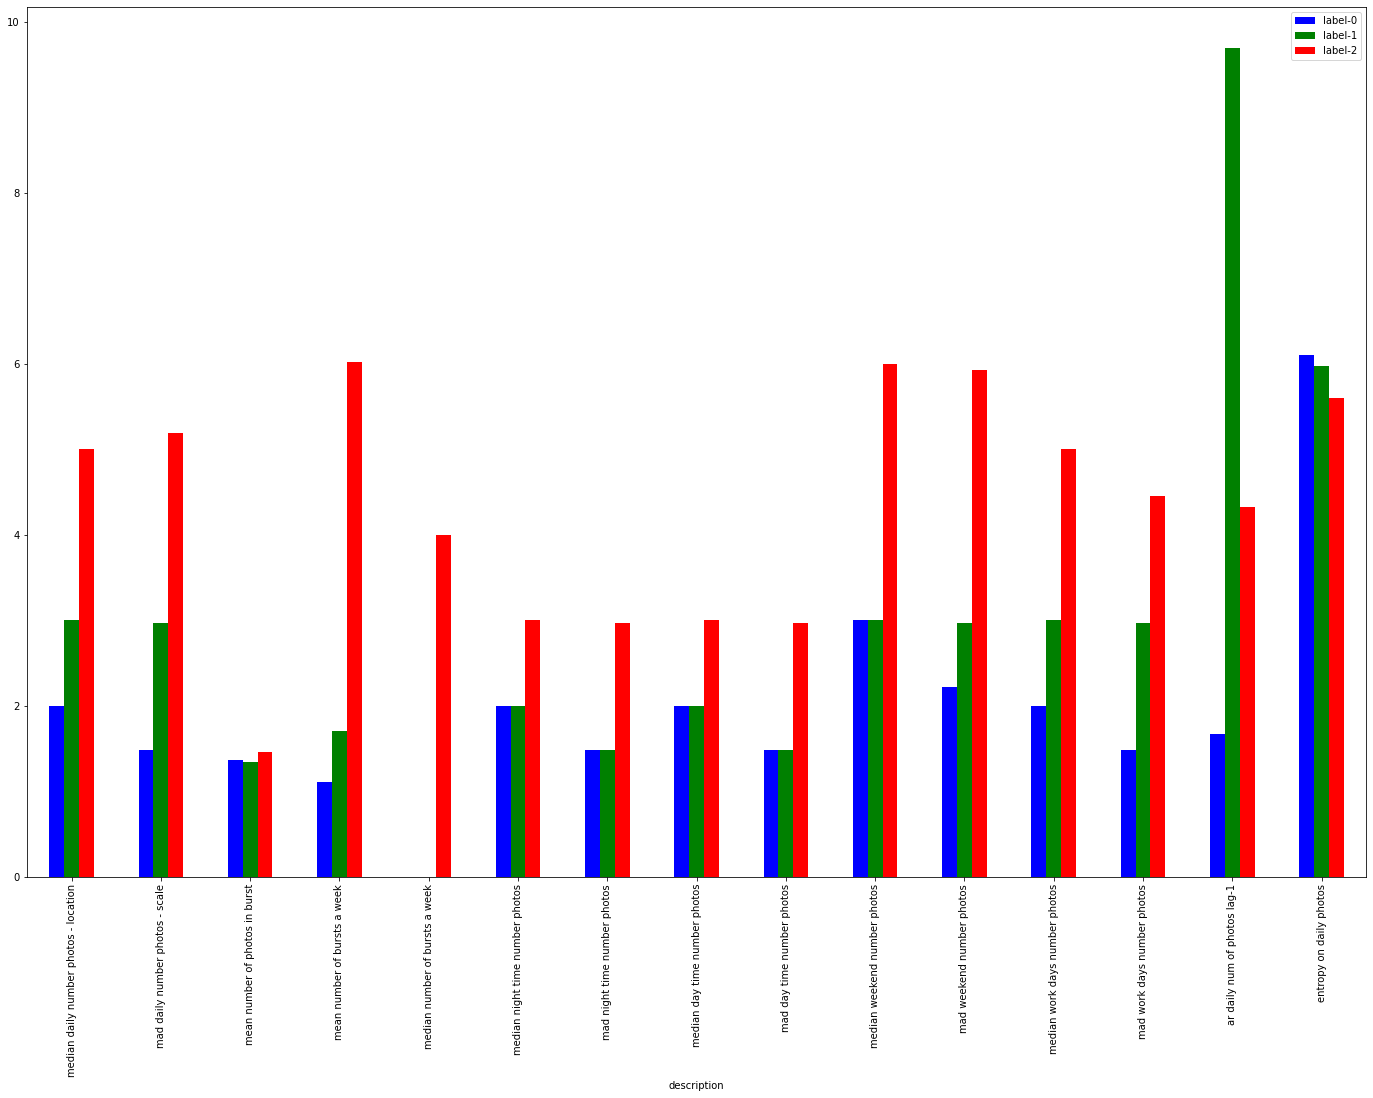

In [97]:
plt.figure()
df_median.plot.bar(color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b'])

<AxesSubplot:xlabel='description'>

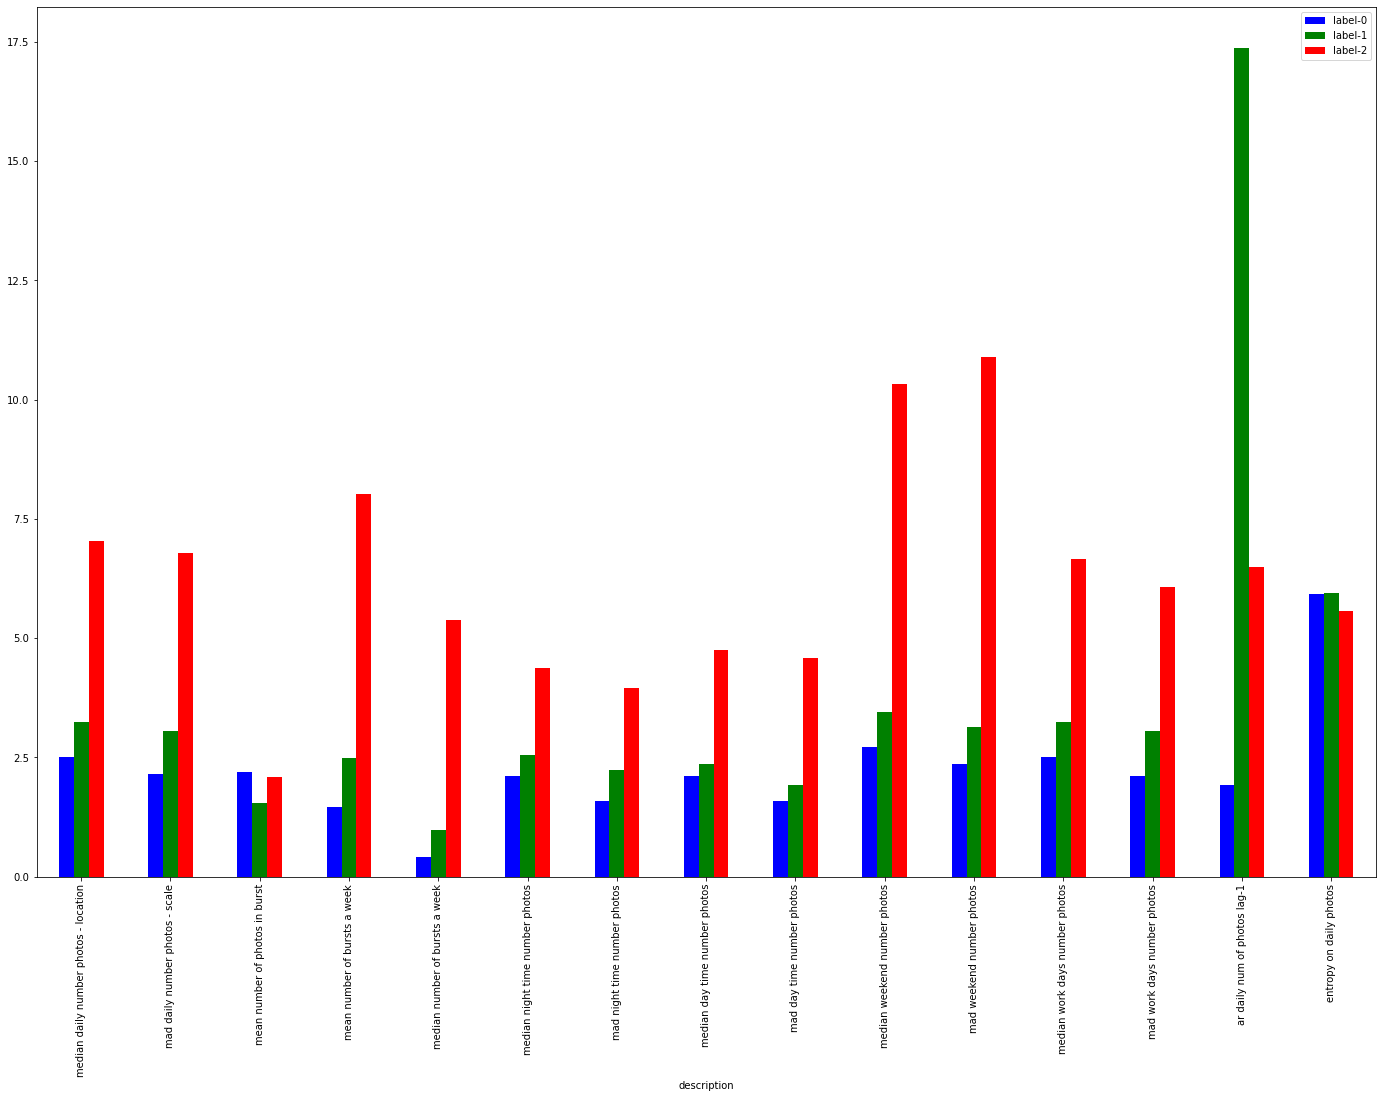

In [103]:
df_mean.plot.bar(color=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'b'])

In [410]:
#X = df_lbl['label-0'].values
#Y = MinCovDet().fit(X)
#Y.covariance_

In [99]:
df_lbl.keys()

dict_keys(['label--1', 'label-0', 'label-1', 'label-2'])

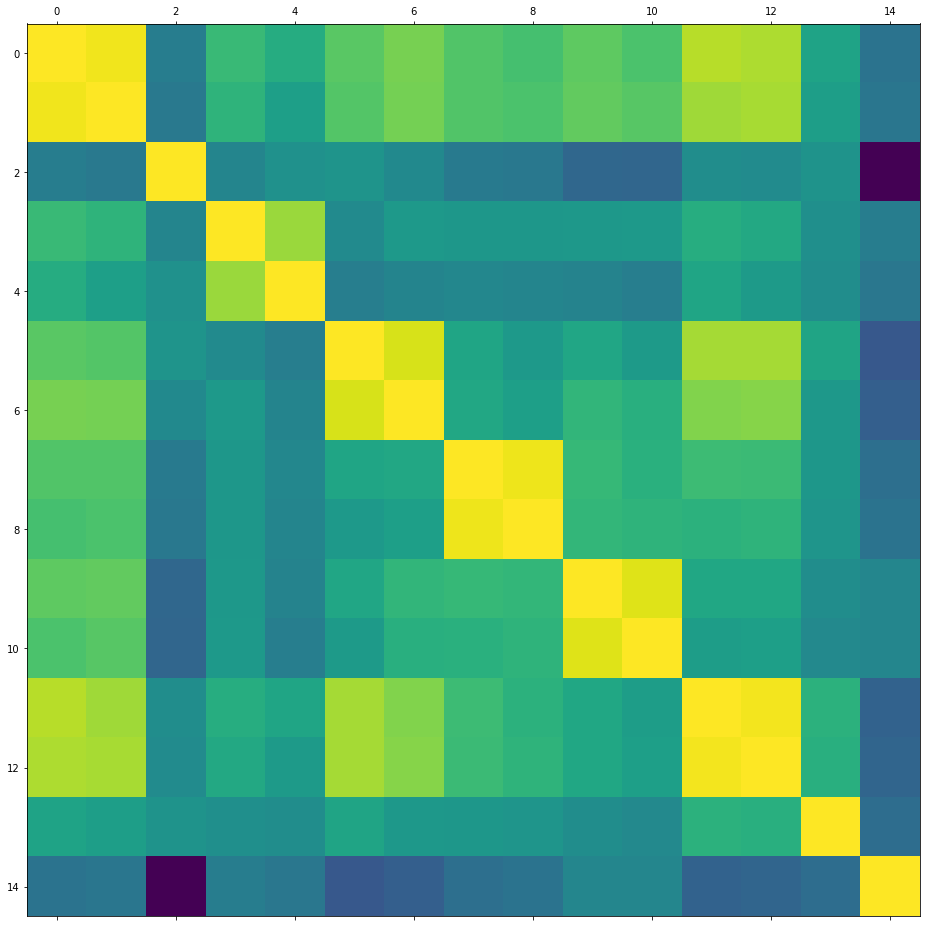

In [100]:
c = df_lbl['label-0'].corr()
plt.matshow(c)
plt.show()

In [264]:
#del df_lbl5['labels']
#dflbl4 = srlbl4.to_frame()
#dflbl4.rename(columns = {0:'lvl-4'})

In [269]:
excel = df0.to_excel('csv_files/photo_gallery_yellow.xlsx')

In [ ]:
#read the tags from firebase json file for user register non register and create df with tag column
def create_tag_df(f): # 'entries.json'
    tag_data = json.load(codecs.open(f, 'r', 'utf-8-sig'))
    df_tag = pd.DataFrame(tag_data)
    df_tag = df_tag.rename(columns={'app_userid': ''})
    dftag = df_tag.set_index('')
    return dftag

In [ ]:
dftag = create_tag_df('entries.json')

In [ ]:
dfjoin = df.join(dftag)

In [ ]:
len(dfjoin)

In [ ]:
dfjoin['User_Register'] = dfjoin['User_Register'].fillna('false')
len(dfjoin[dfjoin.User_Register == 'false'])

In [ ]:
dfjoin.to_csv('csv_files/taged_aggresive_photogallery.csv')

In [ ]:
dfjoin.head(5)

In [ ]:
#sns.scatterplot('population', 'Area', data=df, hue='continent')
#sns.lmplot('population', 'Area', data=df, hue='continent', fit_reg=False)
plt.figure(figsize=(10,8))
sns.lmplot(
    x='x_col', 
    y='y_col',
    data=dfjoin,
    hue='User_Register',
    fit_reg=False,
    height=8,
)
plt.show()

--> tSNE for 3D

In [ ]:
tsne_3d = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300, method='exact')

In [ ]:
nz.shape

In [ ]:
tsne_res_3 = tsne_3d.fit_transform(nz)

In [ ]:
df3 = pd.DataFrame(tsne_res_3, columns=['x_col', 'y_col', 'z_col'], index=inxs)

In [ ]:
df3.head(5)

In [ ]:
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
plt.axis()
ax.scatter(
    xs = df3['x_col'],
    ys = df3['y_col'],
    zs = df3['z_col'],
    cmap='tab2'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
bw = estimate_bandwidth(df3, quantile=0.2, n_samples=200)

In [ ]:
ms = MeanShift(bandwidth=bw, bin_seeding=True)
ms.fit(df3)

In [ ]:
labels = ms.labels_
cluster_centers = ms.cluster_centers_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

In [ ]:
cluster_centers

In [ ]:
fig = plt.figure()
ax = plt.figure(figsize=(16,10)).gca(projection='3d')
ax.view_init(45, 180)
plt.axis()
X = df3.values
colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    my_members = labels == k
    cluster_center = cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], X[my_members, 2], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], cluster_center[2], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
plt.title('Estimated number of 3D clusters: %d' % n_clusters_)
plt.show()

In [ ]:
dfj3 = df3.join(dftag)
dfj3['User_Register'] = dfj3['User_Register'].fillna('false')
dfj3['User_Register'] = dfj3['User_Register'].map({'true': 'blue', 'false': 'red'})

In [ ]:
len(dfj3[dfj3.User_Register == 'blue'])

In [ ]:
%matplotlib inline
#%matplotlib notebook

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
#ax = plt.figure(figsize=(16,10)).gca(projection='3d')
fig = plt.figure()
ax = Axes3D(plt.figure(figsize=(10,8)))
ax.view_init(45, 180)
plt.axis()
ax.scatter(
    xs = dfj3['x_col'],
    ys = dfj3['y_col'],
    zs = dfj3['z_col'],
    c=dfj3['User_Register'],
    cmap='coolwarm'
)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_xlim(-12, 12)
ax.set_ylim(-12, 12)
ax.set_zlim(-12, 12)
plt.show()

In [ ]:
type(ax)